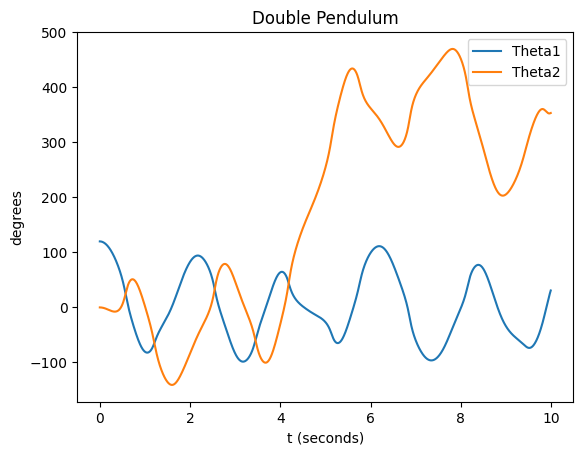

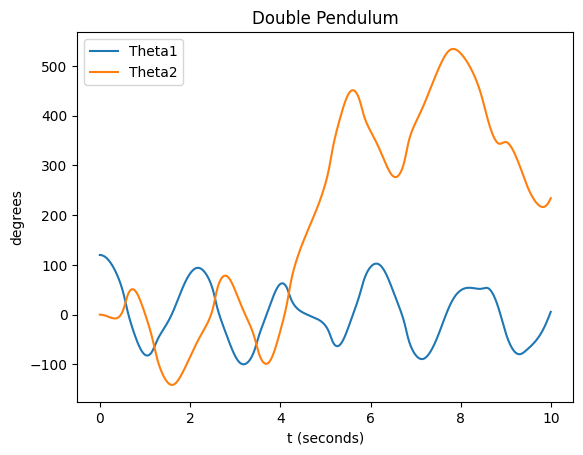

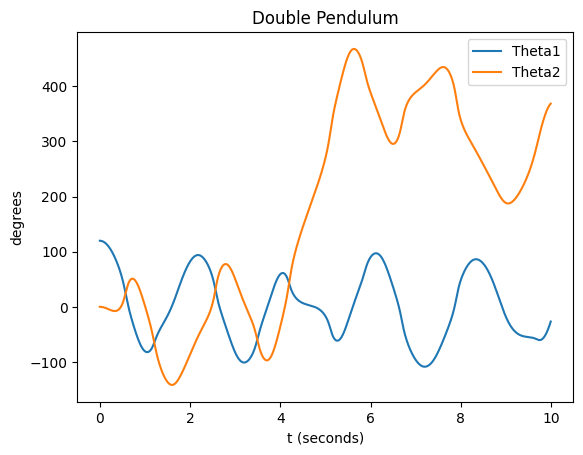

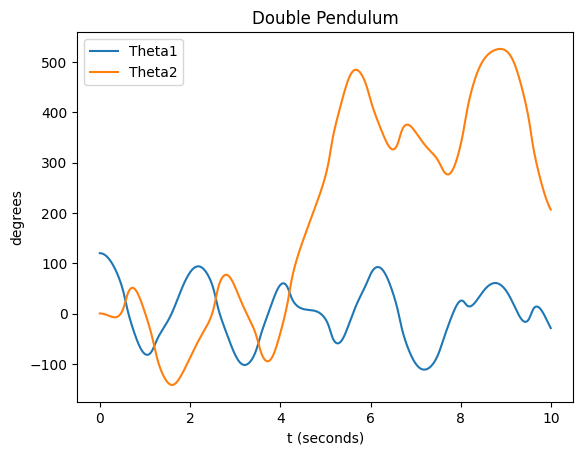

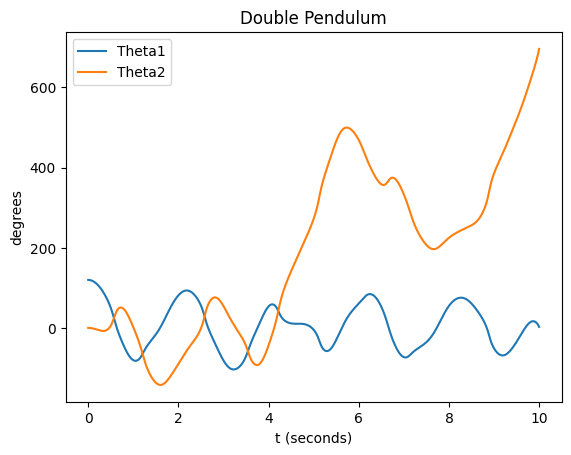

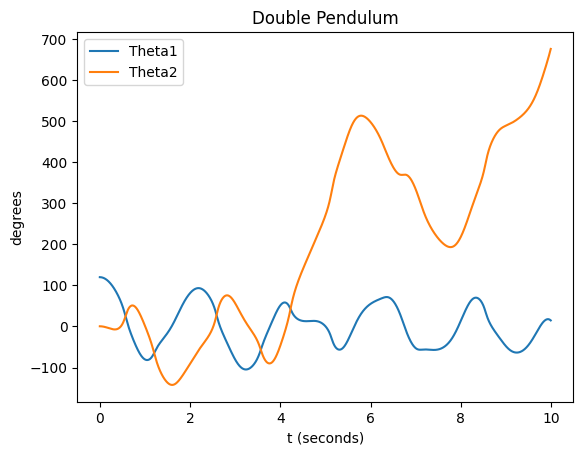

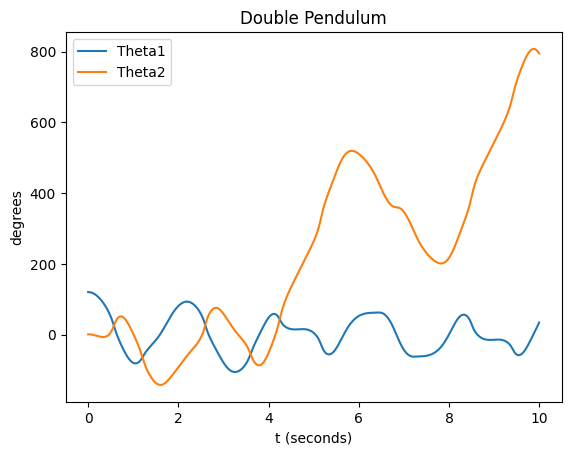

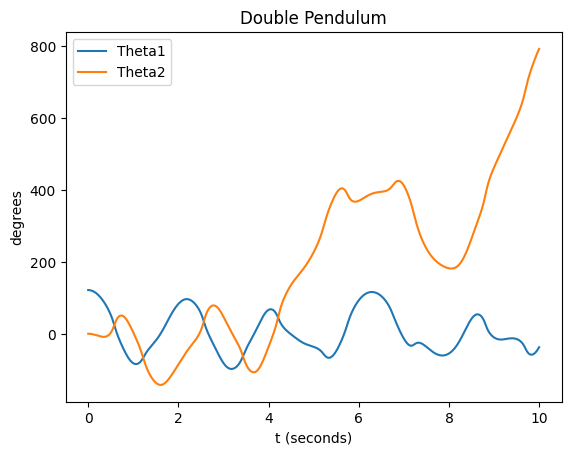

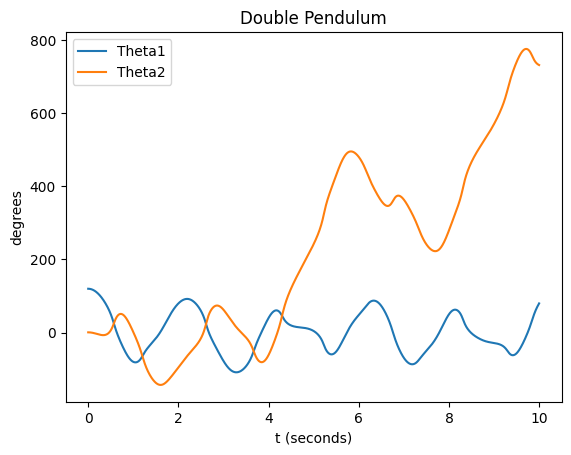

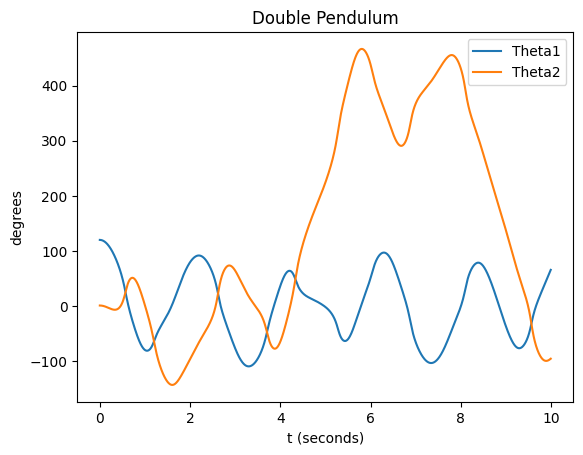

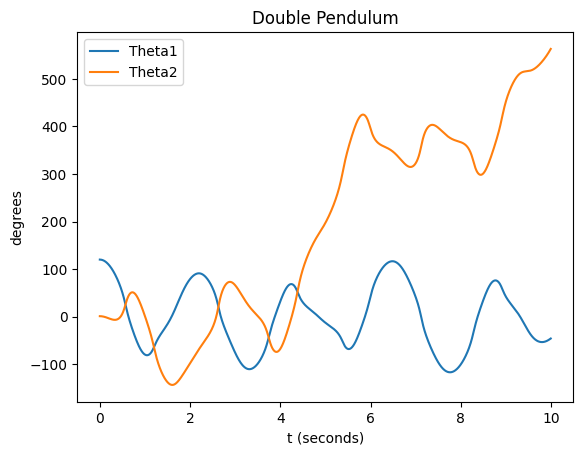

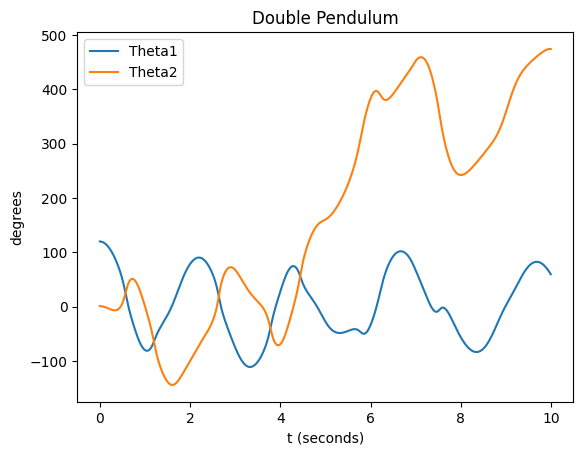

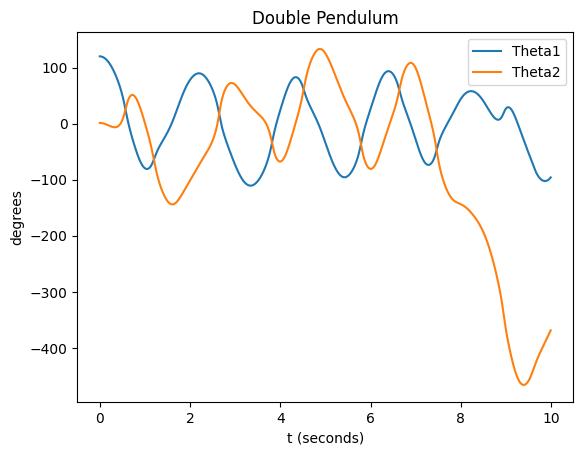

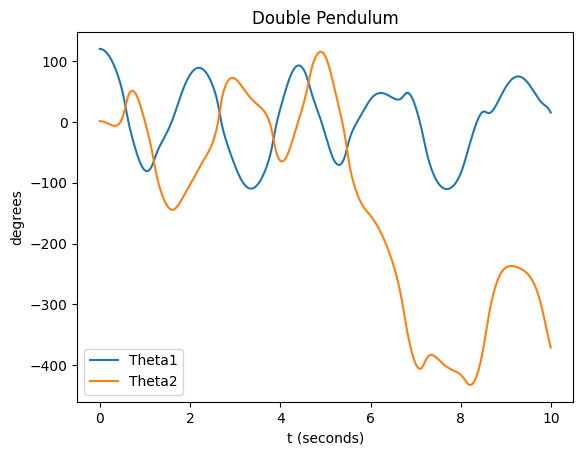

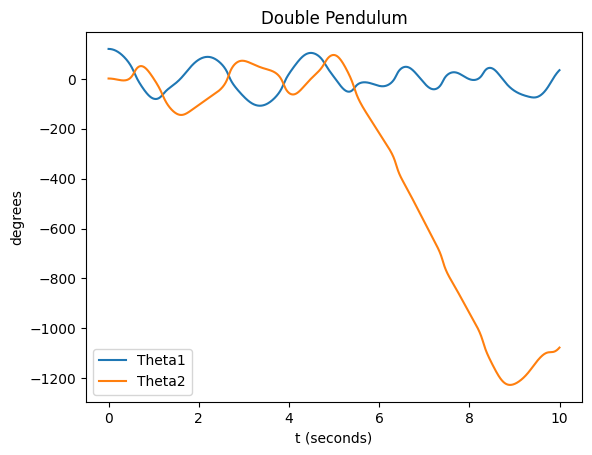

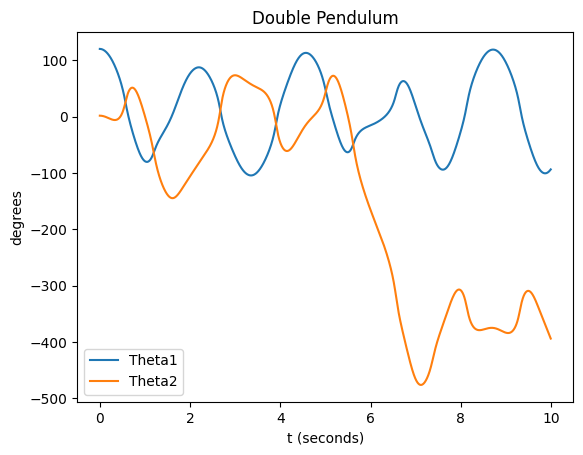

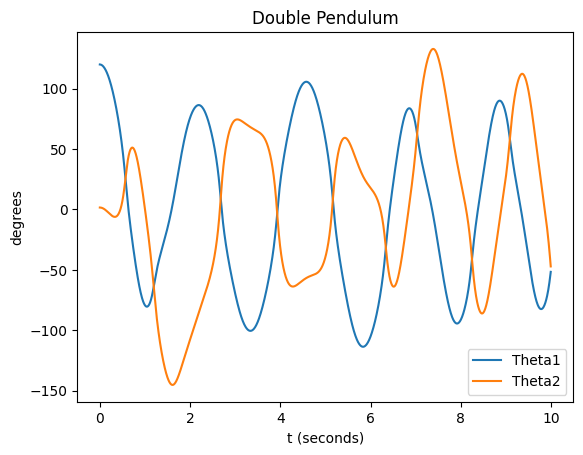

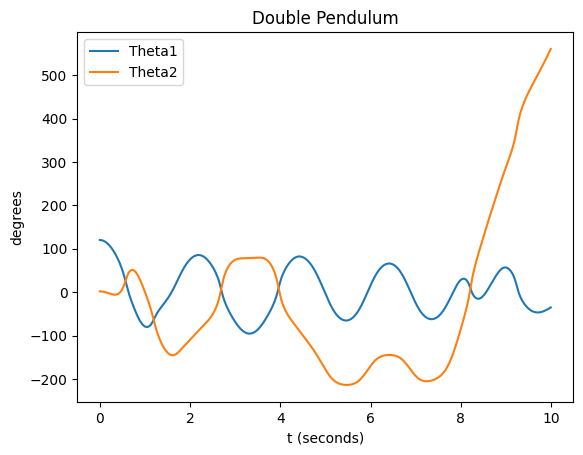

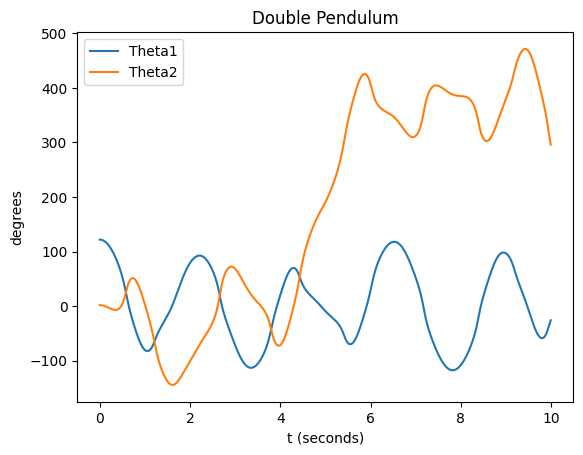

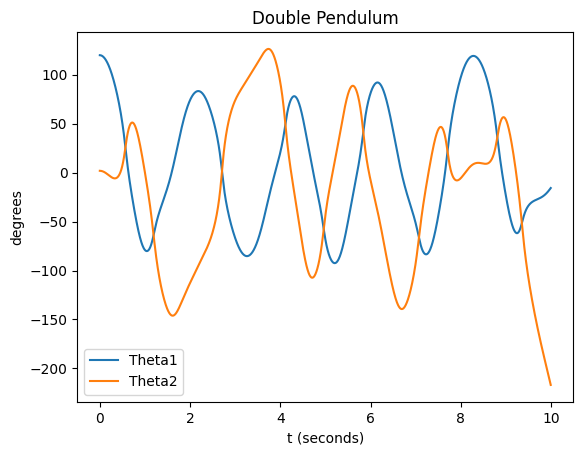

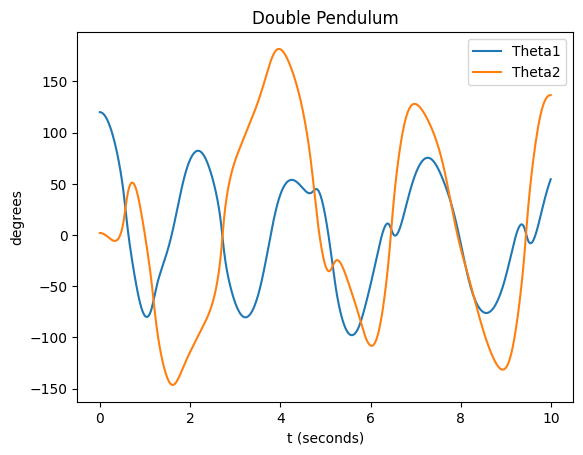

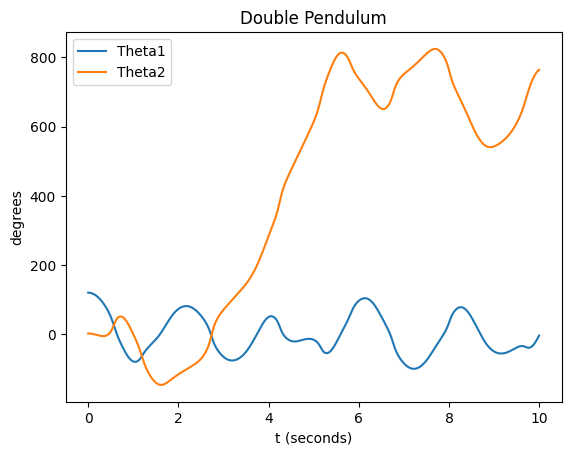

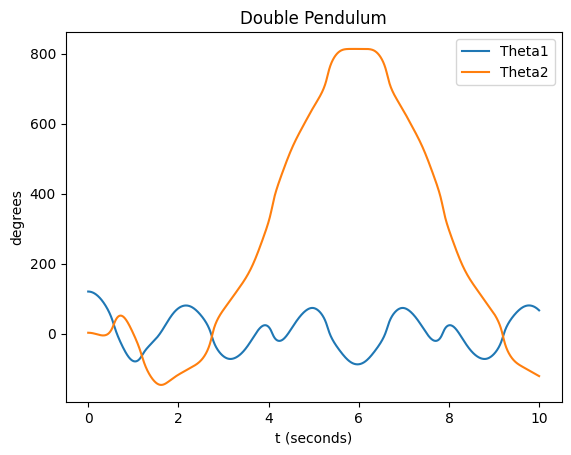

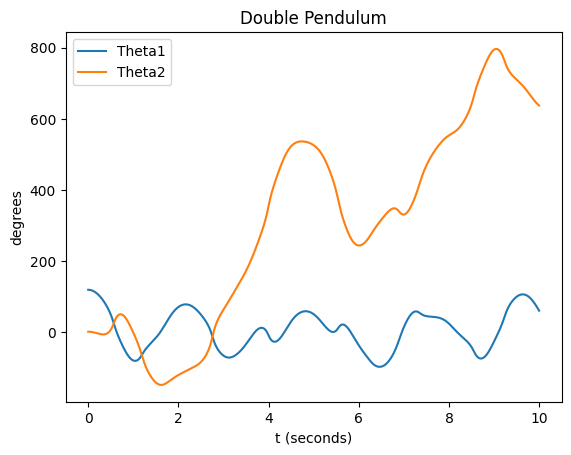

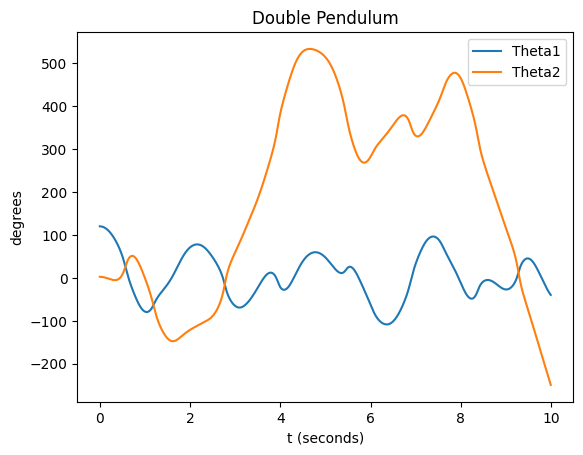

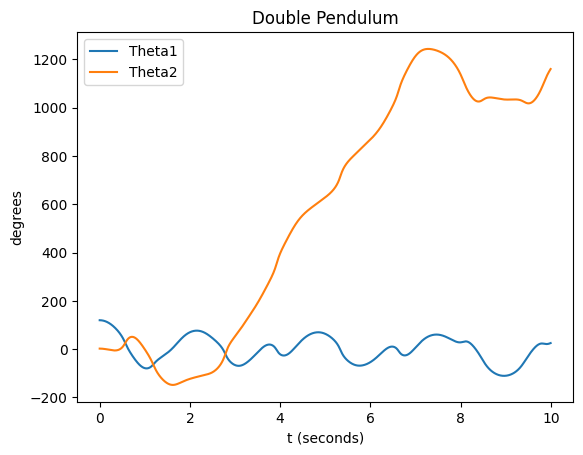

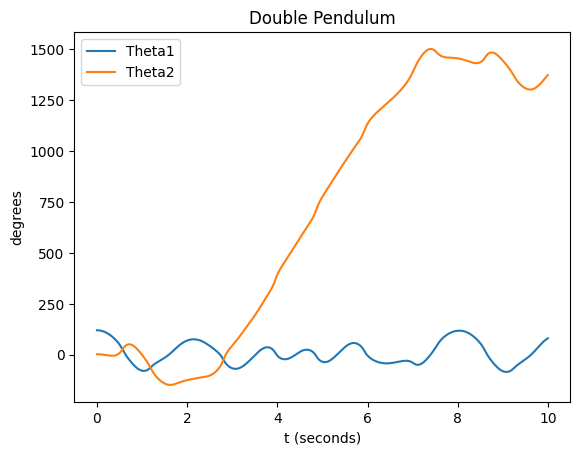

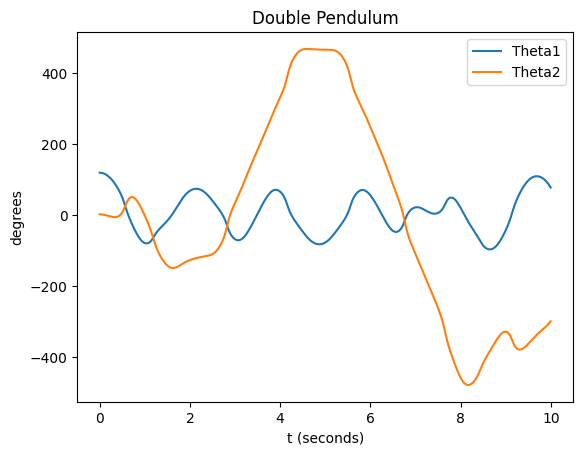

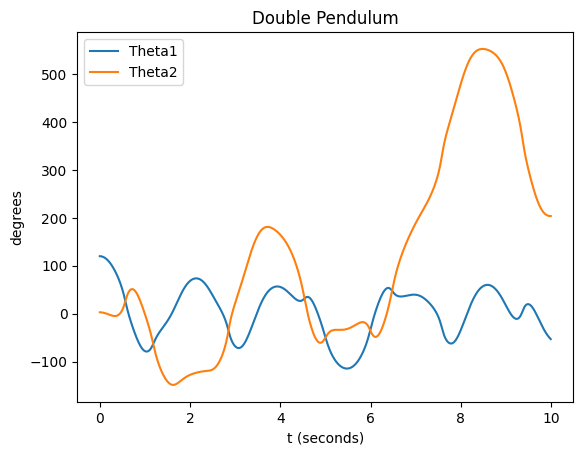

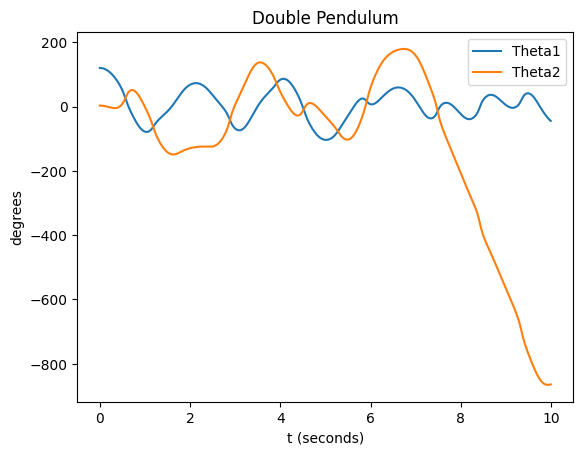

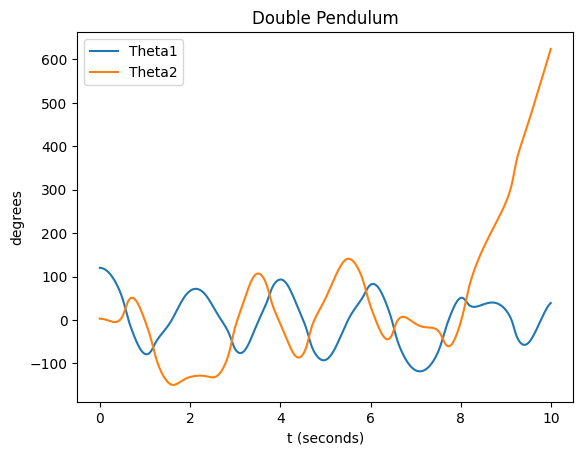

{'120_0': array([[1.        , 0.23065454],
       [0.99996819, 0.23064885],
       [0.99987275, 0.23063178],
       ...,
       [0.57911948, 0.80860828],
       [0.58552784, 0.80893774],
       [0.59182871, 0.80933353]]), '120_0.1': array([[1.        , 0.20918624],
       [0.99996835, 0.20918109],
       [0.99987342, 0.20916564],
       ...,
       [0.46898888, 0.55273565],
       [0.47436783, 0.55423062],
       [0.47975725, 0.55577158]]), '120_0.2': array([[1.        , 0.23244947],
       [0.99996958, 0.23244376],
       [0.99987831, 0.23242664],
       ...,
       [0.3472518 , 0.83562712],
       [0.35285218, 0.83637903],
       [0.35855192, 0.83706956]]), '120_0.3': array([[1.        , 0.21273403],
       [0.99996997, 0.21272881],
       [0.99987988, 0.21271318],
       ...,
       [0.36428471, 0.52432769],
       [0.36048892, 0.52301576],
       [0.35672503, 0.52173624]]), '120_0.4': array([[1.        , 0.16981186],
       [0.99996891, 0.1698077 ],
       [0.99987562, 0.16979526],

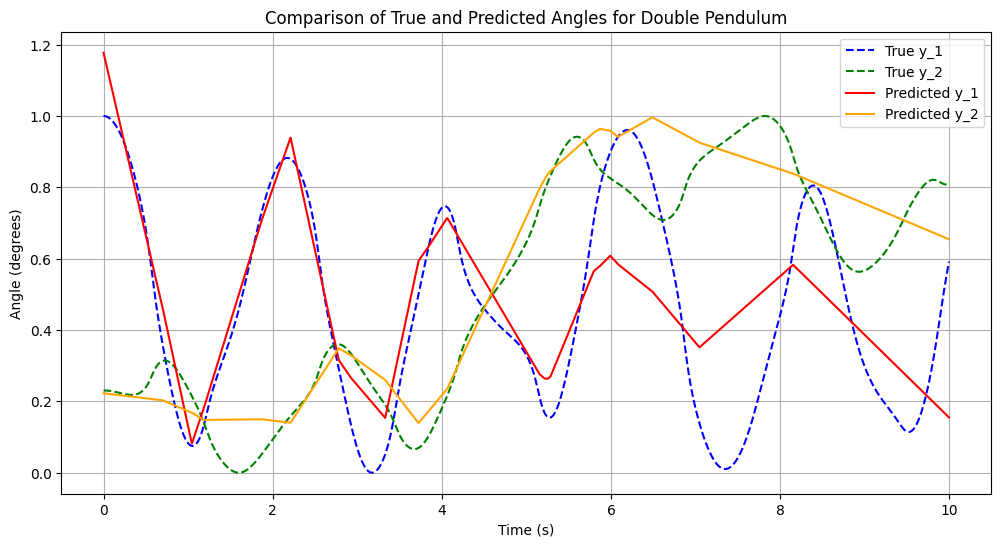

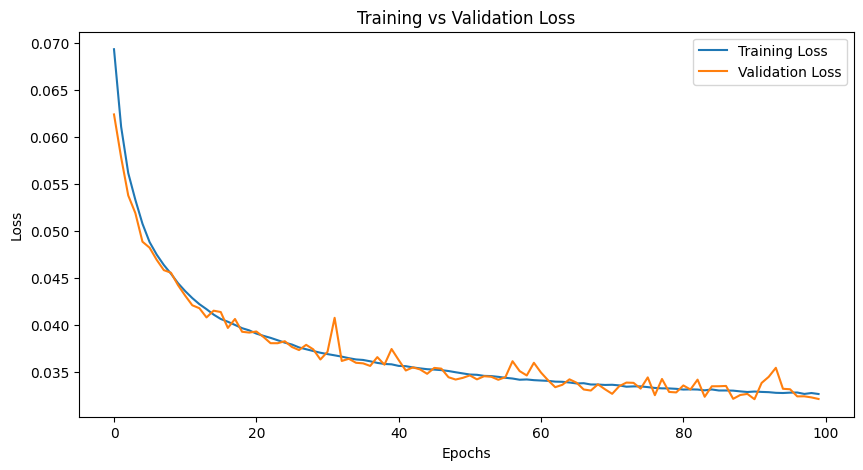

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader

# Double Pendulum Parameters
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Function for Double Pendulum System
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 *
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 *
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

# Simulation Parameters
a = 0.0
b = 10
N = 2000
h = (b - a) / N

angles = [[120, 0], [120, 0.1], [120, 0.2], [120,0.3], [120,0.4], [120,0.5], [120,0.6],[122, 0.7], [120, 0.8], [120,0.9], [120,1], [120, 1.1], [120, 1.2], [120, 1.3], [120,1.4], [120,1.5], [120,1.6], [120,1.7],[122, 1.8], [120, 1.9], [120,2.0], [120,2.1], [120, 2.2], [120, 2.3], [120,2.4], [120,2.5], [120,2.6], [120,2.7], [120, 2.8], [120, 2.9], [120,3.0]]

for x in angles:
    tpoints = np.arange(a, b, h)
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)

    q = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = q[0] * 180 / pi
        theta2_points[i] = q[2] * 180 / pi

        k1 = h * f(q, t, L1, L2)
        k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
        k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
        k4 = h * f(q + k3, t + h, L1, L2)
        q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.title("Double Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("degrees")
    plt.legend()
    plt.show()

    data = np.stack((theta1_points, theta2_points), axis=1)
    np.save(f'pendulum_data_{str(x[0])}_{str(x[1])}.npy', data)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).to(device)  # Shape (N, 3)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'pendulum_data_{str(i[0])}_{str(i[1])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}'] = data_

print(data)

def create_io(data):
    x, x_1, x_2, y_1, y_2 = [], [], [], [], []
    for starting in data:
      starting_theta_1_degrees = float(starting.split("_")[0])
      starting_theta_2_degrees = float(starting.split("_")[1])

      starting_theta_1 = starting_theta_1_degrees * pi /180
      starting_theta_2 = starting_theta_2_degrees * pi /180

      angle_data = data[starting]
      for i in range(len(angle_data)):
          x.append(tpoints[i])
          x_1.append(starting_theta_1)
          x_2.append(starting_theta_2)
          y_1.append(angle_data[i][0])
          y_2.append(angle_data[i][1])
    return x, x_1, x_2, y_1, y_2

x, x_1, x_2, y_1, y_2 = create_io(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_combined = np.vstack([x_1, x_2, x]).T
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2]).T
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(x_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Define the LSTM model class
class AutoregressiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(AutoregressiveModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, num_layers)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size, num_layers)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 3
hidden_size = 50
output_size = 2
num_layers = 3
autoregressive = AutoregressiveModel(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss().to(device)
optimizer = optim.Adam(autoregressive.parameters(), lr=0.001)

early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0


# Training function with early stopping
def train_model(model, train_loader, test_loader, num_epochs):
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            sequences = sequences.squeeze(1)  # Add sequence dimension
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                sequences = sequences.squeeze(1)  # Add sequence dimension
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
                all_preds.append(y_pred.cpu())
                all_targets.append(targets.cpu())

        test_loss /= len(test_loader)
        val_losses.append(test_loss)

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

         # Reshape predictions and targets to 2D before calculating R^2
        all_preds = all_preds.reshape(-1, all_preds.shape[-1])
        all_targets = all_targets.reshape(-1, all_targets.shape[-1])

        r2 = r2_score(all_targets, all_preds, multioutput='uniform_average')
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, R^2 Score: {r2}')

        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(autoregressive.state_dict(), 'autoregressive.pth')

    return train_losses, val_losses

# Training the model
NUM_EPOCHS = 100
train_losses, val_losses = train_model(autoregressive, train_loader, test_loader, NUM_EPOCHS)

# Generate predictions for 120,2
x_dense_combined = np.vstack([x_1[0:2000], x_2[0:2000], x[0:2000]]).T
x_dense_scaled = scaler_x.transform(x_dense_combined)
x_dense_tensor = torch.tensor(x_dense_scaled, dtype=torch.float32).unsqueeze(1).to(device)

autoregressive.eval()
with torch.no_grad():
    y_pred_scaled = autoregressive(x_dense_tensor).cpu().numpy().squeeze(1)



# Inverse transform predictions
y_pred_90_90 = scaler_y.inverse_transform(y_pred_scaled)

# RMSE and R^2 scores
rmse = np.sqrt(mean_squared_error(y_combined[0:2000], y_pred_90_90))
r2 = r2_score(y_combined[0:2000], y_pred_90_90)
print(f"Final RMSE: {rmse}")
print(f"Final R^2 Score: {r2}")

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(x[0:2000], y_1[0:2000], label='True y_1', color='blue', linestyle='--')
plt.plot(x[0:2000], y_2[0:2000], label='True y_2', color='green', linestyle='--')
plt.plot(x[0:2000], y_pred_90_90[:, 0], label='Predicted y_1', color='red')
plt.plot(x[0:2000], y_pred_90_90[:, 1], label='Predicted y_2', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Double Pendulum')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


